## 决策树
    决策树学习是以实例为基础的归纳学习
    决策树学习采用的是自顶向下的递归方法，其基本思想是以信息熵为度量构造一棵熵值下降最快的树。到叶子节点的处的熵值为零，此时每个叶结点中的实例都属于同一类。

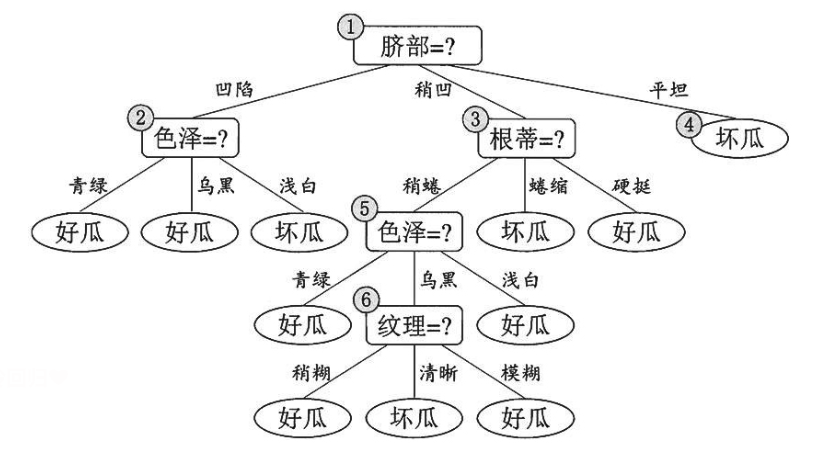

##### 信息熵 Entropy
    熵(entropy)是表示随机变量不确定性的度量。
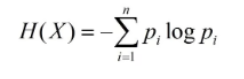

H = -(1*log(1)+0*log(0))=0
H = -(0.4*log(0.4)+0.6*log(0.6))=0.67
H = -(0.5*log(0.5)+0.5*log(0.5))=0.69

In [3]:
import numpy as np
0.4*np.log(0.4)+0.6*np.log(0.6)

-0.6730116670092565

##### 基尼系数 Gini
    也是表示随机变量不确定性的度量。速度比较快，效果差不多。
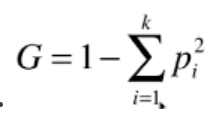

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

def illus_roc_curve(real,pred):
    # Compute ROC curve and ROC area for each class 
    
    fpr,tpr,threshold = roc_curve(real, pred) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'True':FalseNegative,'False':TrueNegative},
                    'Positive':{'True':TruePositive,'False':FalsePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

# data
data = pd.read_csv('D:/BondRiskModel/data_bond/training_data_slim2.csv',index_col=0)
reg_cols = [
        'intercept',       
        'SGI',
        'DEPI',
        'LVGI',
        'TATA',
        'XueIdx_1',
        'XueIdx_4',
        'LOSS',
        'CH_CS',
        'size',
        'lin_1',
        'lin1',
        'lin2',
        'lin3',
        'turnover'
        ]

y = data['if_downgraded'].values
X = data[reg_cols].values
n = int(len(X)*0.7)
X_train = X[:n]
y_train = y[:n]
X_test = X[n:]
y_test = y[n:]

In [2]:
# from sklearn.tree import tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=20)
r = model.fit(X_train,y_train)
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

# confusion_matrix(y_pred_train, y_train)
confusion_matrix(y_pred_test, y_test)


Precision: 0.0
Recall: 0.0

       Negative  Positive
False      6361        49
True         43         0


,Negative,Positive
False,6361,49
True,43,0


### 集成学习：随机森林

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

C:\Users\jason\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### LightGBM

数据分析工作者在机器学习中常用到XGBoost， 多为多个Kaggle冠军的首选， 地位稳固老道。 然后已经开源的LightGBM轻快敏捷，也能够力压群雄。 当然还有其他boosting算法的工具。 究竟他们之间有何区别？ 如何选择合适的工具？

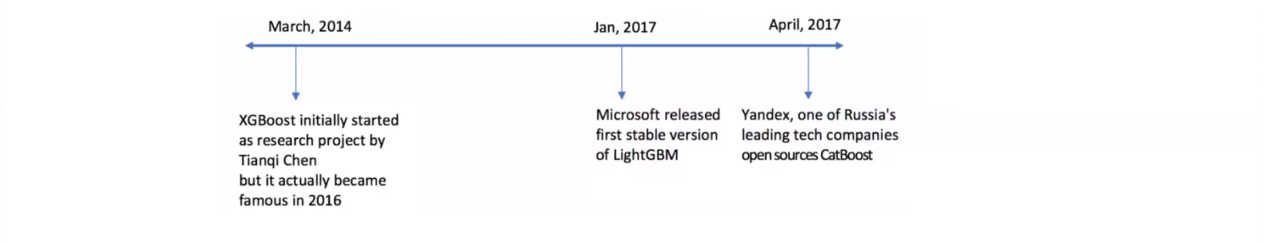

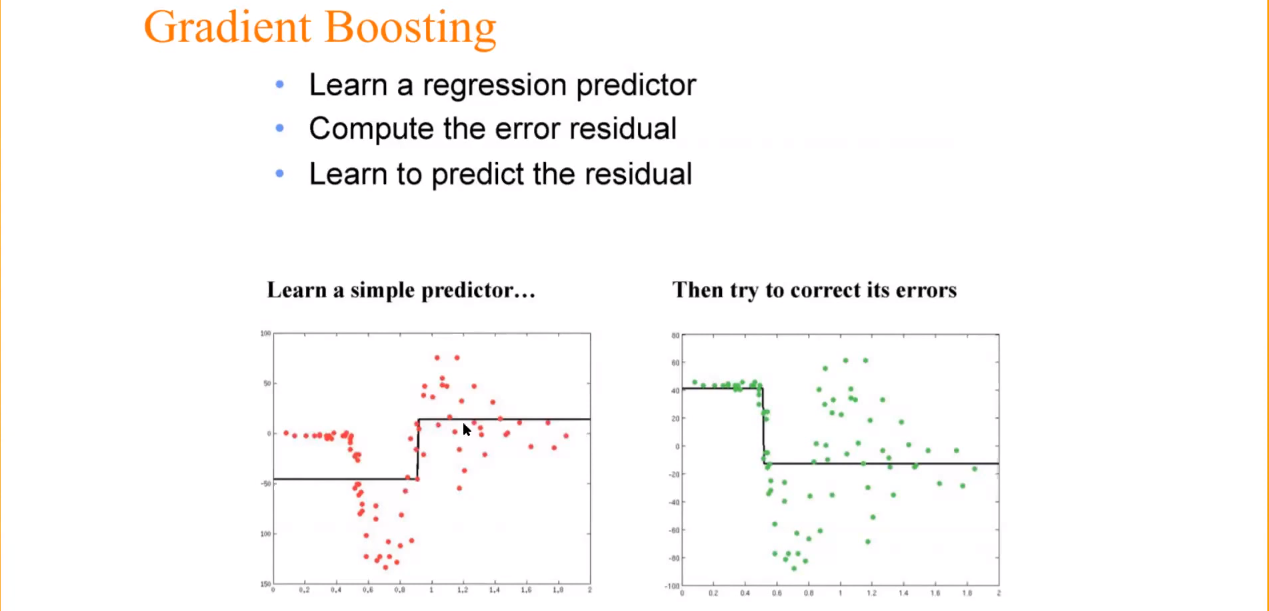

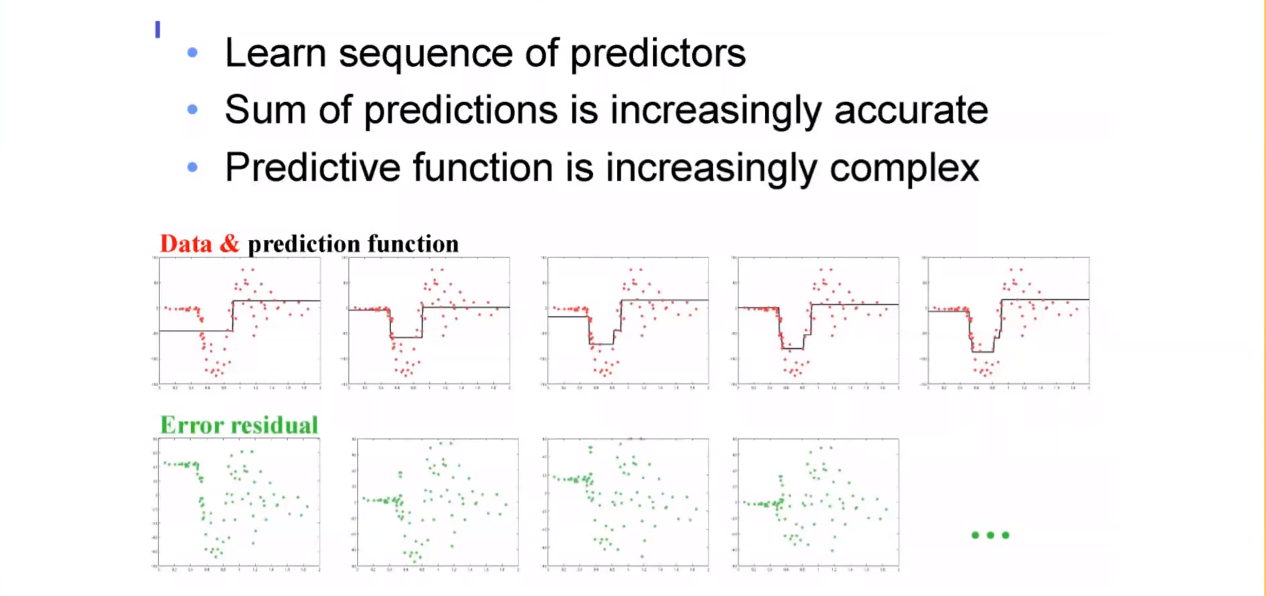

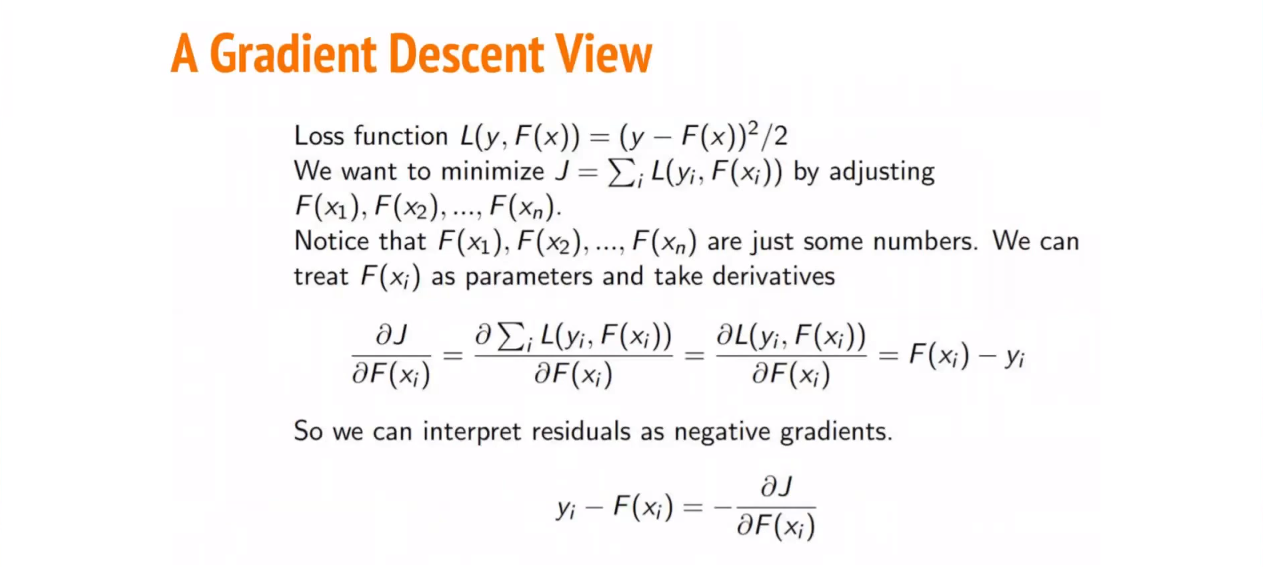

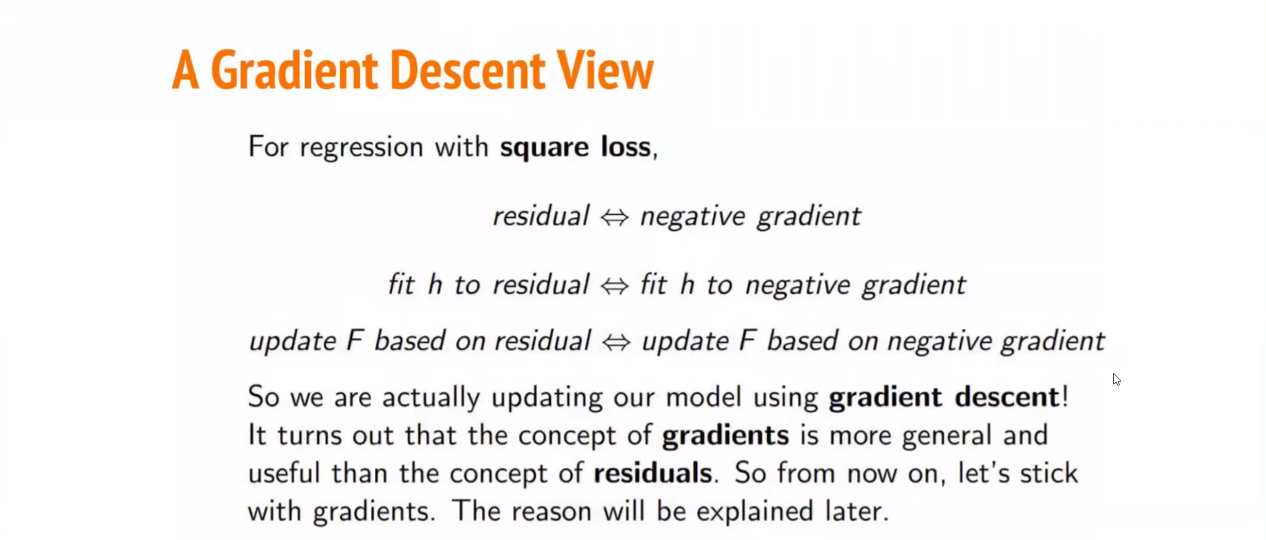

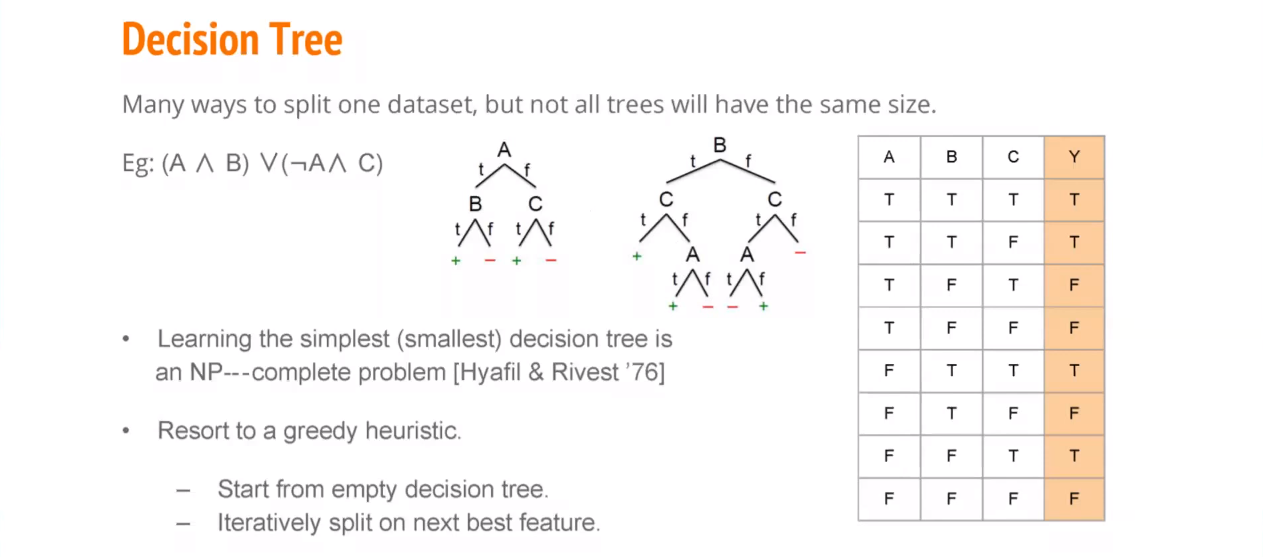

In [7]:
import pandas as pd
import lightgbm as lgb

data = pd.read_csv('D:/BondRiskModel/data_bond/training_data_slim2.csv',index_col=0)
reg_cols = list(data.columns)[:-4]

y = data['if_downgraded']
X = data[reg_cols]
n = int(len(X)*0.5)
X_train = X.iloc[:n]
y_train = y.iloc[:n]
X_test = X.iloc[n:]
y_test = y.iloc[n:]


lgb_train = lgb.Dataset(X_train, y_train, feature_name =reg_cols)
lgb_dev = lgb.Dataset(X_test,y_test, reference = lgb_train)

params = {
    'task':'train',
    'boosting_type':'gbdt',
    'metric': {'l2','fair'},
    'num_leaves':20,
    'num_threads':8,
    'learning_rate':0.02,
    'feature_fraction':0.3,
    'bagging_fraction':0.8
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_dev,
               early_stopping_rounds=10)

x = X[reg_cols]
y_pred = gbm.predict(x, num_iteration = gbm.best_iteration)
gbm.save_model('model.txt')
# illus_roc_curve(y,y_pred)

[1]	valid_0's fair: 0.00182617	valid_0's l2: 0.00591608
Training until validation scores don't improve for 10 rounds
[2]	valid_0's fair: 0.00182574	valid_0's l2: 0.00591293
[3]	valid_0's fair: 0.00182511	valid_0's l2: 0.00590999
[4]	valid_0's fair: 0.0018249	valid_0's l2: 0.00590852
[5]	valid_0's fair: 0.00182462	valid_0's l2: 0.00590701
[6]	valid_0's fair: 0.00182474	valid_0's l2: 0.00590694
[7]	valid_0's fair: 0.0018248	valid_0's l2: 0.00590641
[8]	valid_0's fair: 0.00182512	valid_0's l2: 0.00590621
[9]	valid_0's fair: 0.00182472	valid_0's l2: 0.00590286
[10]	valid_0's fair: 0.00182409	valid_0's l2: 0.00589987
[11]	valid_0's fair: 0.00182421	valid_0's l2: 0.00589884
[12]	valid_0's fair: 0.00182441	valid_0's l2: 0.00589846
[13]	valid_0's fair: 0.00182424	valid_0's l2: 0.00589641
[14]	valid_0's fair: 0.00182407	valid_0's l2: 0.00589419
[15]	valid_0's fair: 0.00182383	valid_0's l2: 0.00589193
[16]	valid_0's fair: 0.00182348	valid_0's l2: 0.0058889
[17]	valid_0's fair: 0.00182326	valid_0

In [61]:
import matplotlib.pyplot as plt


fi = pd.Series(gbm.feature_importance(), index = gbm.feature_name())
fi = fi.sort_values(ascending=False)
fi

NOTES_PAYABLE                        15
NET_CASH_FLOWS_INV_ACT               11
CONST_IN_PROG                        10
ds                                   10
PROJ_MATL                            10
LESS_OPER_COST                        9
free_cash_flow                        9
NET_CASH_FLOWS_OPER_ACT               9
OTH_PAYABLE                           8
TOT_PROFIT                            8
BONDS_PAYABLE                         8
LESS_FIN_EXP                          8
OTHER_CASH_RECP_RAL_FNC_ACT           7
STOT_CASH_INFLOWS_INV_ACT             7
OTH_RCV                               7
Current_Assets                        6
LOSS                                  6
Total_Long_Term_Debt                  6
AMORT_INTANG_ASSETS                   6
Income_from_Continuing_Operations     5
NOTES_RCV                             5
Sales                                 5
MONETARY_CAP                          5
INVEST_REAL_ESTATE                    5
ST_BORROW                             5


In [40]:
for alpha in [0.0046,0.0047,0.00475,0.0048,0.005]:
    print( '--------- {} ---------'.format(alpha))
    pred2 = [1 if x>alpha else 0 for x in y_pred]
    real = y
    confusion_matrix(pred2,real)

--------- 0.0046 ---------

Precision: 0.0076122509663990486
Recall: 1.0

       Negative  Positive
False      4692     16687
True          0       128
--------- 0.0047 ---------

Precision: 0.008241033755274262
Recall: 0.9765625

       Negative  Positive
False      6336     15043
True          3       125
--------- 0.00475 ---------

Precision: 0.00938817726151643
Recall: 0.921875

       Negative  Positive
False      8928     12451
True         10       118
--------- 0.0048 ---------

Precision: 0.009995615957913196
Recall: 0.890625

       Negative  Positive
False     10088     11291
True         14       114
--------- 0.005 ---------

Precision: 0.014274171828709938
Recall: 0.828125

       Negative  Positive
False     14059      7320
True         22       106


### 使用过程

In [1]:
import lightgbm as lgb

In [8]:
import lightgbm as lgb
md = lgb.Booster(model_file='model.txt')

In [4]:
md.predict(x, num_iteration = gbm.best_iteration)

NameError: name 'x' is not defined